# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries
import re
import pyspark
import datetime
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline
import matplotlib.pyplot as plt


from pyspark.sql import Window
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import col, udf
from pyspark.ml.feature import StandardScaler, VectorAssembler
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import LogisticRegression, GBTClassifier,LinearSVC
from pyspark.sql.functions import avg, udf, explode, lit, min, udf, isnull, col, concat, desc, isnan,max, isnull, sum, split


In [2]:
# Let's Create a session of Spark
spark_session  = pyspark.sql.SparkSession.builder.getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [3]:
dframe = spark_session.read.json("mini_sparkify_event_data.json")

In [4]:
dframe.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [5]:
def information(dframe):
    dframe_info = pd.DataFrame(columns = ['Feature','#Nullvalues','#Empetystring','#NonNullvalues','%Non-nullvalues'])
    #Now let's check the null rows in each column count
    count = 0
    row_count = dframe.count()
    for col in dframe.columns:
        null_count = dframe.filter(isnull(dframe[col])).count()
        emptystring_count = dframe.filter(dframe[col].isin('')).count()
        dframe_info.loc[count] = [col,null_count,emptystring_count,(row_count-null_count),(row_count-null_count)/row_count]
        count +=1
    print(dframe_info)    

In [6]:
information(dframe)

          Feature #Nullvalues #Empetystring #NonNullvalues  %Non-nullvalues
0          artist       58392             0         228108         0.796188
1            auth           0             0         286500         1.000000
2       firstName        8346             0         278154         0.970869
3          gender        8346             0         278154         0.970869
4   itemInSession           0             0         286500         1.000000
5        lastName        8346             0         278154         0.970869
6          length       58392             0         228108         0.796188
7           level           0             0         286500         1.000000
8        location        8346             0         278154         0.970869
9          method           0             0         286500         1.000000
10           page           0             0         286500         1.000000
11   registration        8346             0         278154         0.970869
12      sess

In [7]:
row_count = dframe.count()
print("Total No. of Rows in DF is {}".format(dframe.count()))
print("Total No. of Columns in DF is {}".format(len(dframe.columns)))
dframe.describe(dframe.columns[:6]).show()
dframe.describe(dframe.columns[6:13]).show()
dframe.describe(dframe.columns[13:]).show()

Total No. of Rows in DF is 286500
Total No. of Columns in DF is 18
+-------+------------------+----------+---------+------+------------------+--------+
|summary|            artist|      auth|firstName|gender|     itemInSession|lastName|
+-------+------------------+----------+---------+------+------------------+--------+
|  count|            228108|    286500|   278154|278154|            286500|  278154|
|   mean| 551.0852017937219|      null|     null|  null|114.41421291448516|    null|
| stddev|1217.7693079161374|      null|     null|  null|129.76726201140994|    null|
|    min|               !!!| Cancelled| Adelaida|     F|                 0|   Adams|
|    max| ÃÂlafur Arnalds|Logged Out|   Zyonna|     M|              1321|  Wright|
+-------+------------------+----------+---------+------+------------------+--------+

+-------+-----------------+------+-----------------+------+-------+--------------------+-----------------+
|summary|           length| level|         location|method| 

In [8]:
# Let's Drop cells which has missing session_id & user_id
dframe = dframe.dropna(how = 'any', subset = ['sessionId', 'userId'])


In [9]:
# Now Let's remove null empty UserId records
dframe = dframe.filter(dframe['userId'] != '')

In [10]:
print("Total No. of Rows in the DF is {}".format(dframe.count()))
print("Total No. of columns in the DF is {}".format(len(dframe.columns)))

Total No. of Rows in the DF is 278154
Total No. of columns in the DF is 18


# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [11]:
# Let's Represent (TimeStamp & Registration) by creating new cols
new_timestamp = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime("%m-%d-%Y %H:%M:%S"))
dframe = dframe.withColumn('updated_registration', new_timestamp('registration'))
dframe = dframe.withColumn('updated_ts', new_timestamp('ts'))

In [12]:
# Add new col "downgrade_value" to mark it as Submit Downgrade
downgrade_value  = udf(lambda a: 1 if a== "Submit Downgrade" else 0, IntegerType())
dframe = dframe.withColumn("downgrade_value", downgrade_value("page"))

# label users who have downgraded
dg_window = Window.partitionBy('UserId')
dframe = dframe.withColumn("user_downgrade", max('downgrade_value').over(dg_window))

# Add new col "churn_value" to mark it as Cancellation Confirmation event
churn_value = udf(lambda a: 1 if a == 'Cancellation Confirmation' else 0, IntegerType())
dframe = dframe.withColumn("churn_value", churn_value("page"))

# Label's users who have churned
churn_window = Window.partitionBy("userId").rangeBetween(Window.unboundedPreceding, Window.unboundedFollowing)
dframe = dframe.withColumn("user_churn", sum('churn_value').over(churn_window))

Text(0.5,0,'Subscription status')

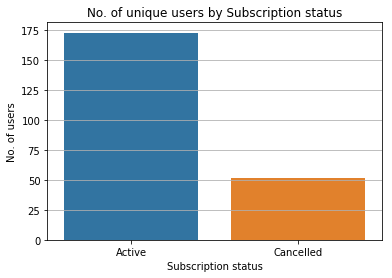

In [13]:
plt.grid(True)
dframe_ch_pd = dframe.drop_duplicates(['userId']).groupby(['user_churn']).count().sort("user_churn").toPandas()
sns.barplot(data = dframe_ch_pd, x = 'user_churn',y = 'count')
churn = ['Active', 'Cancelled']
x_pos = np.arange(len(churn))
plt.xticks(x_pos,churn)
plt.title('No. of unique users by Subscription status')
plt.ylabel('No. of users')
plt.xlabel('Subscription status')

In [14]:
dframe_pandas = dframe.toPandas()

Text(0.5,0,'Subscription status')

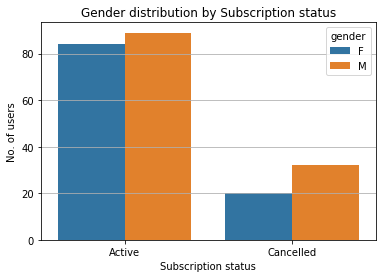

In [15]:
# Plot a Bar to show gender distribution by Subscription status
plt.grid(True)
dframe_ch_pd = dframe.drop_duplicates(['userId', 'gender']).groupby(['user_churn', 'gender']).count().sort("user_churn").toPandas()
sns.barplot(x = 'user_churn', y = 'count', data = dframe_ch_pd, hue = 'gender')
churn = ['Active', 'Cancelled']
y_pos = np.arange(len(churn))
plt.xticks(y_pos,churn)
plt.title("Gender distribution by Subscription status")
plt.ylabel('No. of users')
plt.xlabel('Subscription status')

Text(0.5,0,'Subscription status')

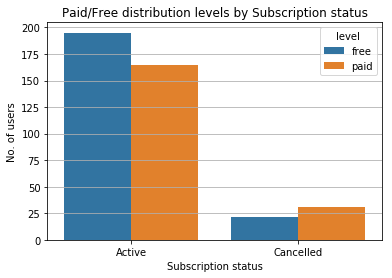

In [16]:
# Plot a Bar plot to show level distribution by Subscription status
plt.grid(True)
level_dframe = dframe.drop_duplicates(['userId','churn_value', 'level']).groupby(['churn_value', 'level']).count().sort("churn_value").toPandas()
sns.barplot(x = 'churn_value', y = 'count', data = level_dframe, hue = 'level')
churn = ['Active', 'Cancelled']
x_pos = np.arange(len(churn))
plt.xticks(x_pos,churn)
plt.title("Paid/Free distribution levels by Subscription status")
plt.ylabel('No. of users')
plt.xlabel('Subscription status')

Text(0.5,0,'% of Envents')

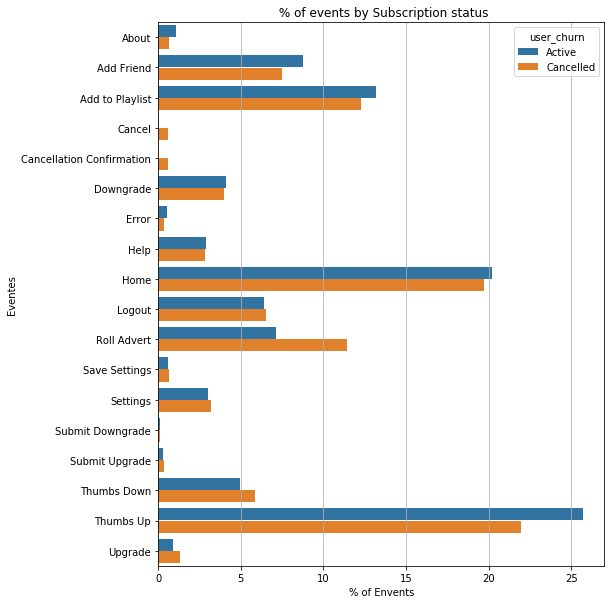

In [17]:
page_dframe = dframe.groupby(['page','user_churn']).count().toPandas()
page_dframe = page_dframe[page_dframe['page'] != 'NextSong']
page_dframe = ((page_dframe.groupby(['page','user_churn']).sum()/page_dframe.groupby(['user_churn']).sum())*100).reset_index()
page_dframe['user_churn'].replace({1: 'Cancelled', 0:'Active'},inplace = True)
plt.figure(figsize=(8,10))
plt.grid(True)
sns.barplot(y = 'page', x = 'count', data = page_dframe, hue = 'user_churn')
plt.title(" % of events by Subscription status")
sns.set_hls_values
plt.ylabel('Eventes')
plt.xlabel('% of Envents')

In [18]:
get_hourly_data = udf(lambda a: datetime.datetime.fromtimestamp(a / 1000.0).hour)
dframe = dframe.withColumn("hour", get_hourly_data(dframe.ts))

get_weekday_data = udf(lambda a: datetime.datetime.fromtimestamp(a / 1000.0).strftime("%w"))
dframe = dframe.withColumn("weekday", get_weekday_data(dframe.ts))

get_daily_data = udf(lambda a: datetime.datetime.fromtimestamp(a / 1000.0).day)
dframe = dframe.withColumn("day", get_daily_data(dframe.ts))

Text(0.5,0,'Hour')

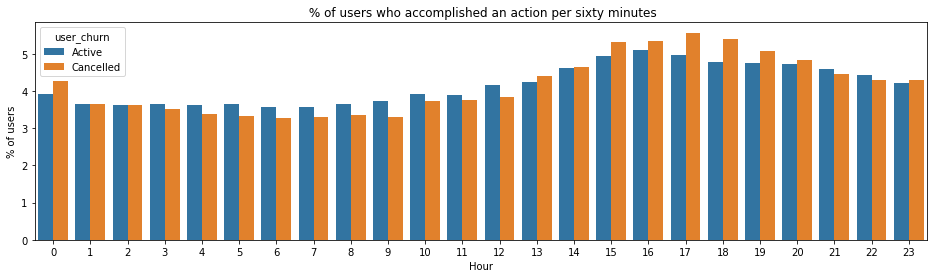

In [19]:
hour_dframe = dframe.groupby(['hour','user_churn']).count().toPandas()
hour_dframe1 = ((hour_dframe.groupby(['hour','user_churn']).sum()/hour_dframe.groupby(['user_churn']).sum())*100).reset_index()
hour_dframe1['hour'] = hour_dframe1['hour'].astype(int)
hour_dframe1['user_churn'].replace({0:'Active', 1: 'Cancelled'},inplace = True)
hour_dframe1.sort_values(by = 'hour', ascending=True,inplace = True)
plt.figure(figsize=(16,4))
sns.barplot(x = 'hour', y = 'count', data = hour_dframe1, hue = 'user_churn')
plt.title(" % of users who accomplished an action per sixty minutes")
sns.set_hls_values
plt.ylabel('% of users')
plt.xlabel('Hour')

Text(0.5,0,'Weekdays')

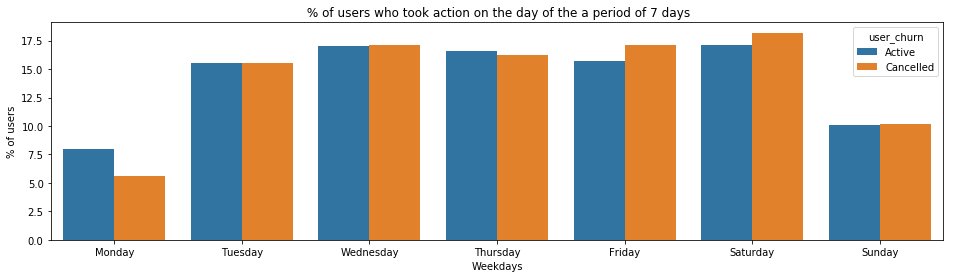

In [20]:
weekday_dframe = dframe.groupby(['weekday','user_churn']).count().toPandas()
weekday_dframe = ((weekday_dframe.groupby(['weekday','user_churn']).sum()/weekday_dframe.groupby(['user_churn']).sum())*100).reset_index()
weekday_dframe['weekday'] = weekday_dframe['weekday'].astype(int)
weekday_dframe['user_churn'].replace({0:'Active', 1: 'Cancelled'},inplace = True)
weekday_dframe.sort_values(by = 'weekday', ascending=True,inplace = True)
plt.figure(figsize=(16,4))
sns.barplot(x = 'weekday', y = 'count', data = weekday_dframe, hue = 'user_churn')
churn = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
x_pos = np.arange(len(churn))
plt.xticks(x_pos,churn)
plt.title(" % of users who took action on the day of the a period of 7 days")
plt.ylabel('% of users')
plt.xlabel('Weekdays')

Text(0.5,0,'day of month')

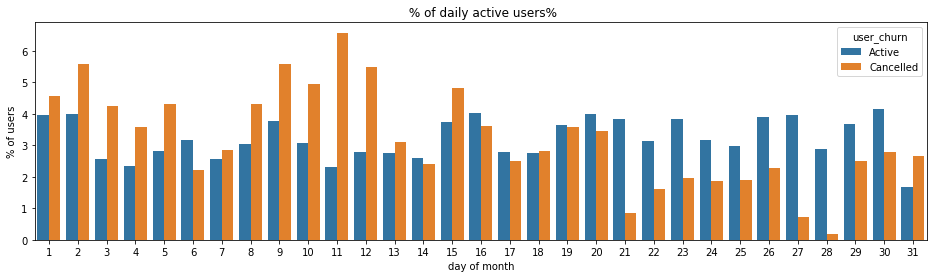

In [21]:
day_dframe = dframe.groupby(['day','user_churn']).count().toPandas()
day_dframe = ((day_dframe.groupby(['day','user_churn']).sum()/day_dframe.groupby(['user_churn']).sum())*100).reset_index()
day_dframe['day'] = day_dframe['day'].astype(int)
day_dframe['user_churn'].replace({1: 'Cancelled', 0:'Active'},inplace = True)
day_dframe.sort_values(by = 'day', ascending=True,inplace = True)
plt.figure(figsize=(16,4))
sns.barplot(x = 'day', y = 'count', data = day_dframe, hue = 'user_churn')
plt.title(" % of daily active users%")
plt.ylabel('% of users')
plt.xlabel('day of month')

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [22]:
# 1st Feature : Total No. of Listened Songs
feature_one = dframe.select('userId', 'song').groupBy('userId').count().withColumnRenamed('count', 'total_songs')

In [23]:
# 2nd Feature : Total Spent Time 
featuer_sec = dframe.select('userID','length').groupBy('userID').agg({'length':'sum'}).withColumnRenamed('sum(length)', 'listen_time')

In [24]:
# 3rd Feature : No. of thumbs-up, 4th Feature : Thumbs-down
feature_third = dframe.select('userID','page').where(dframe.page == 'Thumbs Up').groupBy('userID').agg({'page':'count'}).withColumnRenamed('count(page)', 'up_thumb_num')
feature_fourth = dframe.select('userID','page').where(dframe.page == 'Thumbs Down').groupBy('userID').agg({'page':'count'}).withColumnRenamed('count(page)', 'down_thumb_num')


In [25]:
# 5th Feature : No. of songs added in playlist
feature_fifth = dframe.select('userID','page').where(dframe.page == 'Add to Playlist').groupBy('userID').agg({'page':'count'}).withColumnRenamed('count(page)', 'add_to_playlist')


In [26]:
# 6th Feature : No of Life Time
feature_six = dframe.select('userID','registration','ts').withColumn('lifetime',(dframe.ts-dframe.registration)).groupBy('userID').agg({'lifetime':'max'}).withColumnRenamed('max(lifetime)','lifetime')

In [27]:
# 7th Feature : Total no. of friends
feature_seven = dframe.select('userId', 'page').where(dframe.page == 'Add Friend').groupBy('userId').count().withColumnRenamed('count', 'total_friends')

In [28]:
# 8th Feature : User's Gender
feature_eight = dframe.select('userId', 'gender').dropDuplicates().replace(['F', 'M'], ['0', '1'], 'gender').select('userId', col('gender').cast('int'))

In [29]:
# 9th Feature: No. of help &  10th Feature : No. of rolladvert
feature_nine = dframe.select('userID','page').where(dframe.page == 'Help').groupBy('userID').agg({'page':'count'}).withColumnRenamed('count(page)', 'help') 
feat_ten = dframe.select('userID','page').where(dframe.page == 'Roll Advert').groupBy('userID').agg({'page':'count'}).withColumnRenamed('count(page)', 'roll_advert')

In [30]:
# 11th Feature : Total Songs listened session wise
feature_eleven  = dframe.where('page == "NextSong"').groupby(['userId', 'sessionId']).count().groupby('userId')\
          .agg({'count' : 'avg'}).withColumnRenamed('avg(count)', 'average_played_songs')

In [31]:
# 12th Feature : Total no. of artists which users has listened
feature_twelve = dframe.filter(dframe.page == "NextSong").select("userId", "artist").dropDuplicates().groupby("userId").count()\
         .withColumnRenamed("count", "total_artist_played")

In [32]:
# Now let's set the churn Label for our model
label = dframe.select('userId', col('user_churn').alias('label')).dropDuplicates()

In [33]:
# let's Combine all the features with target churn label's
data  = feature_one.join(featuer_sec,'userID','outer') \
    .join(feature_third,'userID','outer') \
    .join(feature_fourth,'userID','outer') \
    .join(feature_fifth,'userID','outer') \
    .join(feature_six,'userID','outer') \
    .join(feature_seven,'userID','outer') \
    .join(feature_eight,'userID','outer') \
    .join(feature_nine,'userID','outer') \
    .join(feat_ten,'userID','outer') \
    .join(feature_eleven,'userID','outer') \
    .join(feature_twelve,'userID','outer') \
    .join(label,'userID','outer') \
    .drop('userID') \
    .fillna(0)

In [34]:
data.show(6)

+-----------+------------------+------------+--------------+---------------+-----------+-------------+------+----+-----------+--------------------+-------------------+-----+
|total_songs|       listen_time|up_thumb_num|down_thumb_num|add_to_playlist|   lifetime|total_friends|gender|help|roll_advert|average_played_songs|total_artist_played|label|
+-----------+------------------+------------+--------------+---------------+-----------+-------------+------+----+-----------+--------------------+-------------------+-----+
|        381| 66940.89735000003|          17|             5|              7| 4807612000|            4|     0|   2|         52|  39.285714285714285|                252|    0|
|        474| 94008.87593999993|          21|             6|              8| 6054448000|            4|     1|   2|          7|                64.5|                339|    0|
|         11|2089.1131000000005|           0|             0|              0| 6161779000|            0|     1|   0|          1|    

In [35]:

input_columns = ['total_songs',
 'listen_time',
 'up_thumb_num',
 'down_thumb_num',
 'add_to_playlist',
 'lifetime',
 'total_friends',
 'gender',
 'help',
 'roll_advert',
 'average_played_songs',
 'total_artist_played']
fitter = VectorAssembler(inputCols=input_columns, outputCol="NumFeatures")
data = fitter.transform(data)


In [36]:
scalers = StandardScaler(inputCol="NumFeatures", outputCol="features", withStd=True)
scaler_model = scalers.fit(data)
data = scaler_model.transform(data)

In [37]:
data.take(5)

[Row(total_songs=381, listen_time=66940.89735000003, up_thumb_num=17, down_thumb_num=5, add_to_playlist=7, lifetime=4807612000, total_friends=4, gender=0, help=2, roll_advert=52, average_played_songs=39.285714285714285, total_artist_played=252, label=0, NumFeatures=DenseVector([381.0, 66940.8974, 17.0, 5.0, 7.0, 4807612000.0, 4.0, 0.0, 2.0, 52.0, 39.2857, 252.0]), features=DenseVector([0.2866, 0.2431, 0.2596, 0.3823, 0.214, 1.4775, 0.1943, 0.0, 0.2761, 2.413, 0.9219, 0.4173])),
 Row(total_songs=474, listen_time=94008.87593999993, up_thumb_num=21, down_thumb_num=6, add_to_playlist=8, lifetime=6054448000, total_friends=4, gender=1, help=2, roll_advert=7, average_played_songs=64.5, total_artist_played=339, label=0, NumFeatures=DenseVector([474.0, 94008.8759, 21.0, 6.0, 8.0, 6054448000.0, 4.0, 1.0, 2.0, 7.0, 64.5, 339.0]), features=DenseVector([0.3565, 0.3414, 0.3207, 0.4588, 0.2445, 1.8606, 0.1943, 2.0013, 0.2761, 0.3248, 1.5135, 0.5613])),
 Row(total_songs=11, listen_time=2089.1131000000

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [38]:
final_data = data.select('label','features')

In [39]:
final_data.take(2)

[Row(label=0, features=DenseVector([0.2866, 0.2431, 0.2596, 0.3823, 0.214, 1.4775, 0.1943, 0.0, 0.2761, 2.413, 0.9219, 0.4173])),
 Row(label=0, features=DenseVector([0.3565, 0.3414, 0.3207, 0.4588, 0.2445, 1.8606, 0.1943, 2.0013, 0.2761, 0.3248, 1.5135, 0.5613]))]

In [40]:
train_set,validation_set = final_data.randomSplit([0.8, 0.2], seed=50)

In [41]:
# Now let's train the model (Use multiple models and check performance)
logistic_regression = LogisticRegression(maxIter=10, regParam =0.0)
gbt_classifier = GBTClassifier(maxDepth = 5, maxIter = 10, seed = 42)
linear_svm = LinearSVC (maxIter = 10,  regParam = 0.01)

In [42]:
# Logistic Regression
evaluator = MulticlassClassificationEvaluator(metricName='f1')
param_map = ParamGridBuilder() \
    .addGrid(logistic_regression.regParam,[0.0, 0.05, 0.1]) \
    .build()
cross_val = CrossValidator(estimator=logistic_regression,
                          estimatorParamMaps=param_map,
                          evaluator=evaluator,
                          numFolds=3)
cv_model = cross_val.fit(train_set)
cv_model.avgMetrics

[0.7524039440691163, 0.6959410072071835, 0.6876278792946842]

In [43]:
# Support_Vector_Machine 
evaluator = MulticlassClassificationEvaluator(metricName='f1')
param_map = ParamGridBuilder() \
    .addGrid(linear_svm.regParam,[0.01, 0.05, 0.5]) \
    .build()
cross_val = CrossValidator(estimator=linear_svm,
                          estimatorParamMaps=param_map,
                          evaluator=evaluator,
                          numFolds=3)
cv_model2 = cross_val.fit(train_set)
cv_model2.avgMetrics

[0.6759010504014384, 0.6759010504014384, 0.6759010504014384]

In [44]:
# Gradient Boosted Tree
evaluator = MulticlassClassificationEvaluator(metricName='f1')
param_map = ParamGridBuilder() \
    .addGrid(gbt_classifier.maxDepth,[5, 10]) \
    .build()
cross_val = CrossValidator(estimator=gbt_classifier,
                          estimatorParamMaps=param_map,
                          evaluator=evaluator,
                          numFolds=3)
cv_model3 = cross_val.fit(train_set)
cv_model3.avgMetrics

[0.7265717227836672, 0.7167141707798639]

In [45]:
gbt_tune = GBTClassifier(maxDepth=6,maxIter=12,seed=42)
model_gbt = gbt_tune.fit(train_set)
output = model_gbt.transform(validation_set)

In [46]:
evaluation = MulticlassClassificationEvaluator(predictionCol="prediction")
print(evaluation.evaluate(output, {evaluation.metricName: "accuracy"}))

0.7027027027027027


In [48]:
print(evaluation.evaluate(output, {evaluation.metricName: "f1"}))

0.7155241494864136


In [49]:
model_gbt.featureImportances

SparseVector(12, {0: 0.1405, 1: 0.046, 2: 0.1174, 3: 0.0889, 4: 0.0441, 5: 0.258, 6: 0.1293, 7: 0.0039, 8: 0.0363, 9: 0.0666, 10: 0.0679, 11: 0.001})

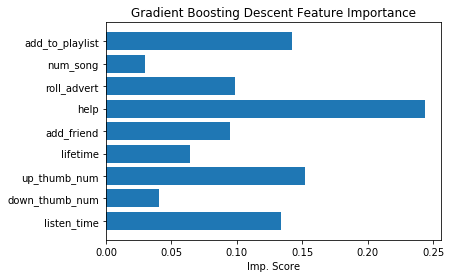

In [50]:
feature_important  = [ 0.134,0.0408,0.1519,0.0639,0.0946,0.2436,0.0988,0.0301,0.1421]
feature = ["listen_time", "down_thumb_num", \
          'up_thumb_num','lifetime','add_friend','help','roll_advert', "num_song", 'add_to_playlist']
y_pos = np.arange(len(feature))
 
plt.barh(y_pos, feature_important, align='center')
plt.yticks(y_pos, feature)
plt.xlabel('Imp. Score')
plt.title('Gradient Boosting Descent Feature Importance')
plt.savefig('Gradient Boosting Descent feature Importance.png', dpi=500)

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.